<img src="https://s0.cptec.inpe.br/webcptec/sites/www/assets/img/logo_cptec.png" align="right" width="64"/>

# <div style="text-align: center;"><span style="color:#336699; font-size: 1.2em;">1º Love Data Day - BIG TechTalks:<br><span style="color:#336699; font-style: italic;">      Usando Dados de Precipitação e STAC Browser para Avaliar o "Dia do Fogo em SP"</span></span></div>
<hr style="border:2px solid #0077b9;">

<br/>

<div style="text-align: center;font-size: 90%;">
    Alex de Almeida Fernandes<sup><a href="https://orcid.org/0000-0003-1520-5896"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    Divisão de Previsão de Tempo e Clima, Instituto Nacional de Pesquisas Espaciais (INPE)
    <br/>
    Rodovia Presidente Dutra, km 40, Cachoeira Paulista, SP 12630-000, Brazil
    <br/><br/>
    Contato: <a href="mailto:alex.fernandes@inpe.br">alex.fernandes@inpe.br</a>
    <br/><br/>
    Ultíma Atualização: 27 de Maio de 2025
</div>

<br/>

<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Resumo.</b> Este Jupyter Notebook é parte do BIG TechTalks, edição especial <i>Love Data Days</i> - Acesso, Visualização e Processamento de dados de precipitação diária acumulada do dado MERGE produzido no INPE. O dado MERGE consiste na combinação dos dados de superfície das estações em conformidade com o padrão da Organização Meteorológica Mundial e dados de estimativas de precipitação por satélite IMERG/GPM. Esta combinação torna a estimativa de satélite mais precisa e permite o uso em locais onde não há observações de superfície nas proximidades. Este Jupyter Notebook apresenta uma visão geral de como utilizar o serviço STAC na linguagem Python para descoberta e acesso aos produtos de dados de sensoriamento remoto disponíveis no catálogo do INPE, além de demonstrar a abertura de arquivos no formato GRIB2 e como visualizar os dados de precipitação.
<br/><br/>
<b>Referências.</b><br> 
<a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2020.1763504 " target="_blank">Performance of precipitation products obtained from combinations of satellite and surface observations</a>
<a href="https://doi.org/10.3390/rs10060882 " target="_blank">Evaluation of TRMM/GPM Blended Daily Products over Brazil</a>
</div>



In [1]:
%pip install xarray cfgrib netcdf4
%pip install cartopy
%pip install geopandas
%pip install regionmask

#%pip show cartopy
#%pip show cfgrib

%reset -f

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import pystac_client
import pystac
import itertools
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from dateutil.parser import parse

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['PROJ_LIB'] = "/opt/conda/envs/geospatial/share/proj"


In [3]:
#PySTAC
service = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')
service

<Client id=INPE>

In [4]:
collection = service.get_collection('prec_merge_daily-1')
collection

<CollectionClient id=prec_merge_daily-1>

In [7]:
def download_and_read_merge_stac(
    stac_service: str,
    start_date: str,
    end_date: str,
    output_dir: str = "merge_data"
):
    """
    Busca, baixa e lê dados MERGE em formato GRIB2 de um catálogo STAC,
    filtrando por um período de datas. 

    Args:
        stac_catalog_url (str): URL do catálogo/item STAC do INPE que contém o MERGE diário.
        start_date (str): Data inicial (formato ISO ou legível, ex: '2024-01-01').
        end_date (str): Data final (formato ISO ou legível, ex: '2024-01-31').
        output_dir (str): Pasta onde salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset final contendo os dados do merge com a dimensão tempo.
    """
    # Converte datas para objetos datetime
    start_dt = parse(start_date)
    end_dt = parse(end_date)

    # Cria diretório de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    downloaded_files = []

    if isinstance(service, pystac.Catalog) and stac_service.id == 'INPE':
        item_search = service.search(datetime=start_date+'/'+end_date,
                             collections=['prec_merge_daily-1'])
        for asset in item_search.items():
            if asset.assets['merge_daily'].href.endswith(".grib2"):
                file_url = asset.assets['merge_daily'].href
                filename = Path(file_url).name
                file_path = output_path / filename

                #print(f"Baixando: {file_url}")
                response = requests.get(file_url, stream=True)
                response.raise_for_status()

                with open(file_path, "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024 * 1024):
                        if chunk:
                            f.write(chunk)

                        print(f"Arquivo salvo: {file_path}")
                        downloaded_files.append(file_path)
    else:
        raise ValueError("STAC URL deve apontar para um Catálogo ou Item.")

    # Verifica se algum arquivo foi baixado
    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo .grib2 foi encontrado no período especificado.")

    # Lê os arquivos com xarray
    print("Lendo arquivos com xarray...")
          
    # Lê múltiplos arquivos com open_mfdataset, aplicando a função preprocess
    ds = xr.open_mfdataset(
        downloaded_files,
        engine='cfgrib',
        combine='nested',
        concat_dim='time',
        decode_timedelta=False)

    return ds

ds = download_and_read_merge_stac(service, '2024-05-01', '2024-08-31', '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp')
ds = ds.sortby('time')
ds

Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240901.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240831.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240830.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240829.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240828.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240827.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240826.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240825.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240824.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_C

Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240901.grib2.5b7b6.idx' older than GRIB file


Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240503.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240502.grib2
Arquivo salvo: /home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240501.grib2
Lendo arquivos com xarray...


Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240831.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240830.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240829.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240828.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240827.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240826.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/jovyan/code-gallery/jupyter/events/data-love-days/tmp/MERGE_CPTEC_20240825.grib2.5b7b6.idx' older than GRIB file
Ignoring index file 

<xarray.Dataset> Size: 918MB
Dimensions:     (time: 124, latitude: 924, longitude: 1001)
Coordinates:
  * time        (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
    step        float64 8B 0.0
    surface     float64 8B 2.55e+03
  * latitude    (latitude) float64 7kB -60.05 -59.95 -59.85 ... 32.15 32.25
  * longitude   (longitude) float64 8kB 239.9 240.0 240.1 ... 339.8 339.9 339.9
    valid_time  (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
Data variables:
    rdp         (time, latitude, longitude) float32 459MB dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
    prmsl       (time, latitude, longitude) float32 459MB dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2025-06-01T22:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
def plot_precipitacao_merge(
    ds,
    var='rdp',
    title='Precipitação Total (MERGE)',
    cmap='YlGnBu',
    levels=np.linspace(0, 50, 51),
    extent=[-85, -34, -60, 15]  # Extent da América do Sul
):
    """
    Plota a variável de precipitação do dataset MERGE para a América do Sul.

    Args:
        ds (xarray.Dataset): Dataset com os dados lidos (ex: de xr.open_dataset).
        var (str): Nome da variável de precipitação. Padrão: 'tp' (total precipitation).
        title (str): Título do gráfico.
        cmap (str): Colormap usado.
        levels (array): Níveis do contorno para o plot.
        extent (list): [min_lon, max_lon, min_lat, max_lat] da região a ser plotada.
    """
    # Definir projeção
    proj = ccrs.PlateCarree()

    # Criar figura e eixo com projeção geográfica
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

    # Seleciona a variável e plota
    pcm = ds[var].plot.pcolormesh(
        ax=ax,
        transform=proj,
        cmap=cmap,
        levels=levels,
        extend='max',
        add_colorbar=True,
        cbar_kwargs={'shrink': 0.7, 'label': 'Precipitação (mm/h)'}
    )

    # Configurações do mapa
    ax.set_title(title, fontsize=14)
    ax.set_extent(extent, crs=proj)

    # Adicionar limites continentais e países
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.5)

    # Grid e rótulos
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.tight_layout()
    plt.show()

<xarray.Dataset> Size: 7MB
Dimensions:    (latitude: 924, longitude: 1001)
Coordinates:
    step       float64 8B 0.0
    surface    float64 8B 2.55e+03
  * latitude   (latitude) float64 7kB -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude  (longitude) float64 8kB 239.9 240.0 240.1 ... 339.8 339.9 339.9
Data variables:
    rdp        (latitude, longitude) float32 4MB dask.array<chunksize=(924, 1001), meta=np.ndarray>
    prmsl      (latitude, longitude) float32 4MB dask.array<chunksize=(924, 1001), meta=np.ndarray>


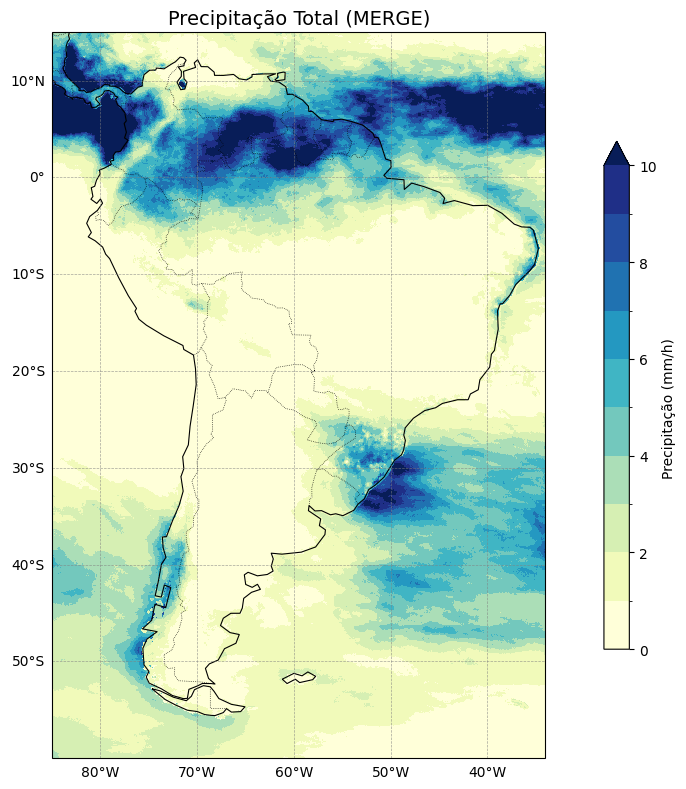

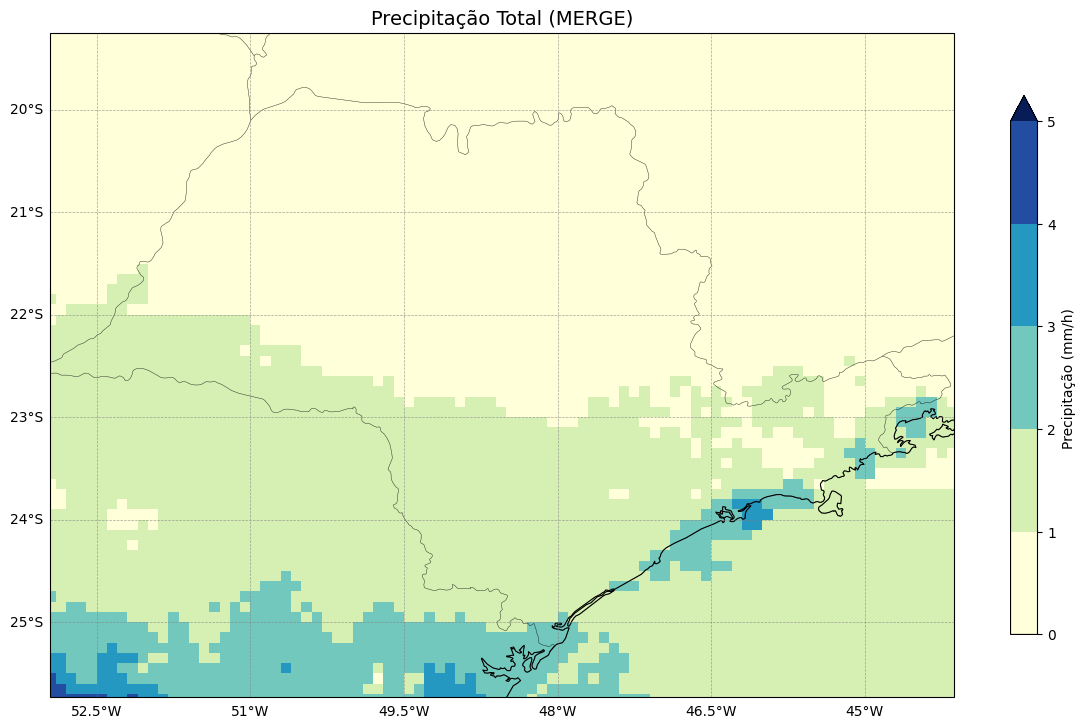

In [10]:
dy = ds.mean(dim='time')
print(dy)

plot_precipitacao_merge(dy, levels=np.linspace(0, 10, 11))
plot_precipitacao_merge(ds.mean(dim='time'), extent=[-52.9518,-44.1291,-25.7323,-19.2479], levels=np.linspace(0, 5, 6))


In [11]:
def recortar_dataset_por_regiao(ds, lon_min, lon_max, lat_min, lat_max):
    """
    Recorta o dataset ou dataArray para uma região retangular definida por lat/lon.

    Args:
        ds (xarray.Dataset or xarray.DataArray): O dataset ou array a ser recortado.
        lon_min (float): Longitude mínima da região.
        lon_max (float): Longitude máxima da região.
        lat_min (float): Latitude mínima da região.
        lat_max (float): Latitude máxima da região.

    Returns:
        xarray.Dataset or xarray.DataArray: Dataset/DataArray recortado para a região especificada.
    """
    # Verifica se as dimensões estão corretas
    if 'latitude' in ds.dims and 'longitude' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            longitude=slice(360+lon_min, 360+lon_max),
            latitude=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
        )
    elif 'lat' in ds.dims and 'lon' in ds.dims:
        # Aplica o recorte
        recortado = ds.sel(
            lon=slice(lon_min, lon_max),
            lat=slice(lat_min,lat_max)  # Ordem decrescente em latitude é comum em datasets
    )
        
    else:
        raise ValueError("O dataset deve conter as dimensões 'latitude' e 'longitude'.")


    return recortado

In [12]:
# Aplicar máscara
#ds_sp = mask_sp_dataset_ibge_2024(ds)
ds_sp = recortar_dataset_por_regiao(ds, -52.9518,-45.2291,-22,-19.2479)
ds_sp



<xarray.Dataset> Size: 2MB
Dimensions:     (time: 124, latitude: 28, longitude: 78)
Coordinates:
  * time        (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
    step        float64 8B 0.0
    surface     float64 8B 2.55e+03
  * latitude    (latitude) float64 224B -21.95 -21.85 -21.75 ... -19.35 -19.25
  * longitude   (longitude) float64 624B 307.1 307.2 307.3 ... 314.6 314.7 314.8
    valid_time  (time) datetime64[ns] 992B 2024-05-01T12:00:00 ... 2024-09-01...
Data variables:
    rdp         (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 28, 78), meta=np.ndarray>
    prmsl       (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 28, 78), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2025-06-01T22:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [63]:
#plot_precipitacao_merge(ds_sp.mean(dim='time'), 
#                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
#                        levels=np.linspace(0, 2, 21),
#                        cmap = 'RdBu')
#
#ds_sp['rdp'].max(axis=[1,2]).plot(figsize=(12, 5))
#plt.show()


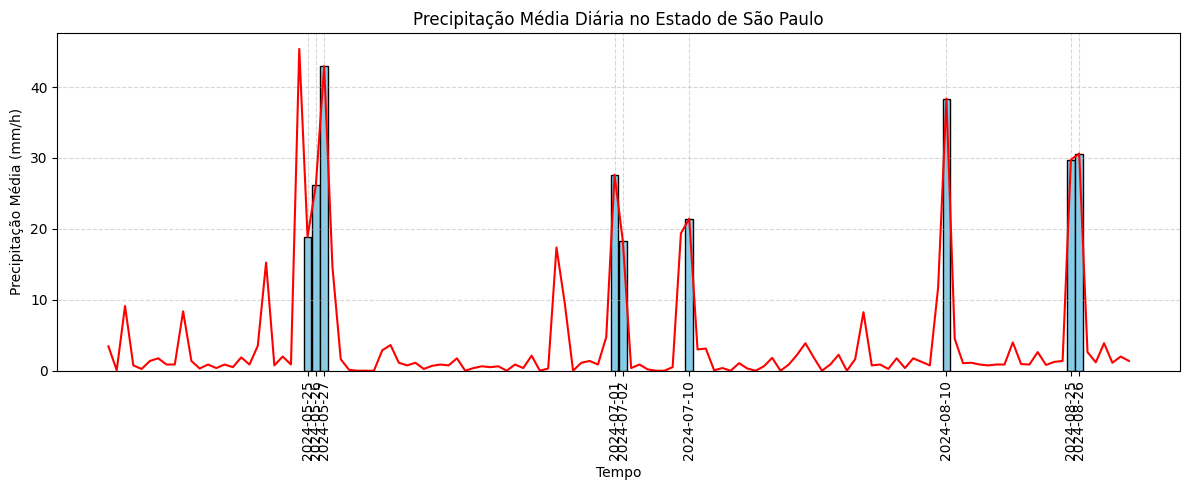

In [75]:
dt = ds_sp['time'][ds_sp['rdp'].mean(axis=[1,2]).values > 1]
tp = ds_sp['rdp'][ds_sp['rdp'].mean(axis=[1,2]).values > 1].max(axis=[1,2])

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(dt, tp, width=0.9, color='skyblue', edgecolor='black')
ax.plot(ds_sp['time'],ds_sp['rdp'].max(axis=[1,2]), color='red')
# Mostrar todas as datas
dates = pd.to_datetime(dt.values)
formatted_labels = dates.strftime('%Y-%m-%d')
ax.set_xticks(dt)  # Força todos os ticks
ax.set_xticklabels(formatted_labels, rotation=90)

ax.set_xlabel('Tempo')
ax.set_ylabel('Precipitação Média (mm/h)')
ax.set_title('Precipitação Média Diária no Estado de São Paulo')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

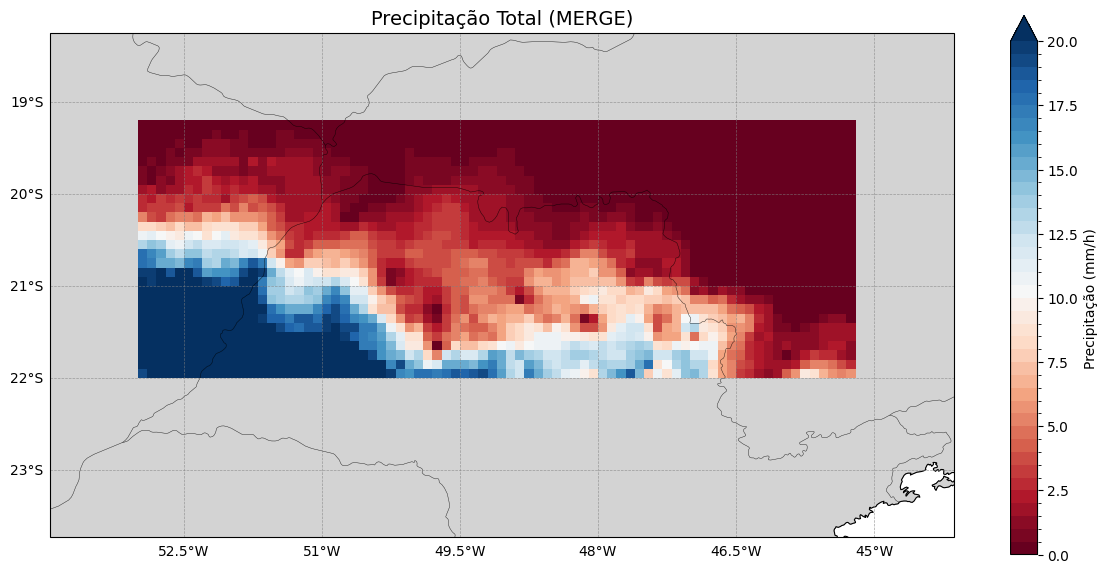

In [62]:
plot_precipitacao_merge(ds_sp.sel(time='2024-08-10').mean(dim='time'), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 20, 41),
                        cmap = 'RdBu')


In [76]:
def download_mlt_precipitation_data(
    start_date='2024-05-01',
    end_date='2024-08-31',
    output_dir='mlt_data'
):
    """
    Baixa e carrega dados MERGE-LT de precipitação entre duas datas, usando o formato %d%b no nome do arquivo.

    Args:
        start_date (str): Data inicial (formato 'YYYY-MM-DD').
        end_date (str): Data final (formato 'YYYY-MM-DD').
        output_dir (str): Pasta local para salvar os arquivos baixados.

    Returns:
        ds (xarray.Dataset): Dataset com todos os dados concatenados.
    """
    # Criar pasta de saída se não existir
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Gerar lista de datas
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    downloaded_files = []

    for dt in date_range:
        # Formato dia + mês abreviado em minúsculo (ex: '01jun', '31ago')
        day_month = dt.strftime('%d%b').lower()  # '29Mar' -> '29mar'

        filename = f"MERGE_CPTEC_12Z{day_month}.nc"
        file_url = f"https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/{filename}"

        file_path = output_path / filename

        print(f"Tentando baixar: {file_url}")

        response = requests.get(file_url, stream=True)

        if response.status_code == 200:
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):
                    if chunk:
                        f.write(chunk)
            downloaded_files.append(file_path)
        else:
            print(f"Arquivo não encontrado: {file_url}")

    if not downloaded_files:
        raise FileNotFoundError("Nenhum arquivo foi baixado.")

    print(f"{len(downloaded_files)} arquivos baixados. Carregando com xarray...")

    # Abrir múltiplos arquivos com xarray
    ds = xr.open_mfdataset(
        downloaded_files,
        combine='by_coords'
    )

    return ds

In [77]:
ds_mlt = download_mlt_precipitation_data()

Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z01may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z02may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z03may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z04may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z05may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z06may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z07may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/DAILY_AVERAGE/MERGE_CPTEC_12Z08may.nc
Tentando baixar: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/G

In [78]:
ds_mlt


<xarray.Dataset> Size: 375MB
Dimensions:  (time: 123, lat: 691, lon: 551)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 984B 2020-05-01T12:00:00 ... 2020-08-31T12...
Data variables:
    pmed     (time, lat, lon) float64 375MB dask.array<chunksize=(1, 691, 551), meta=np.ndarray>

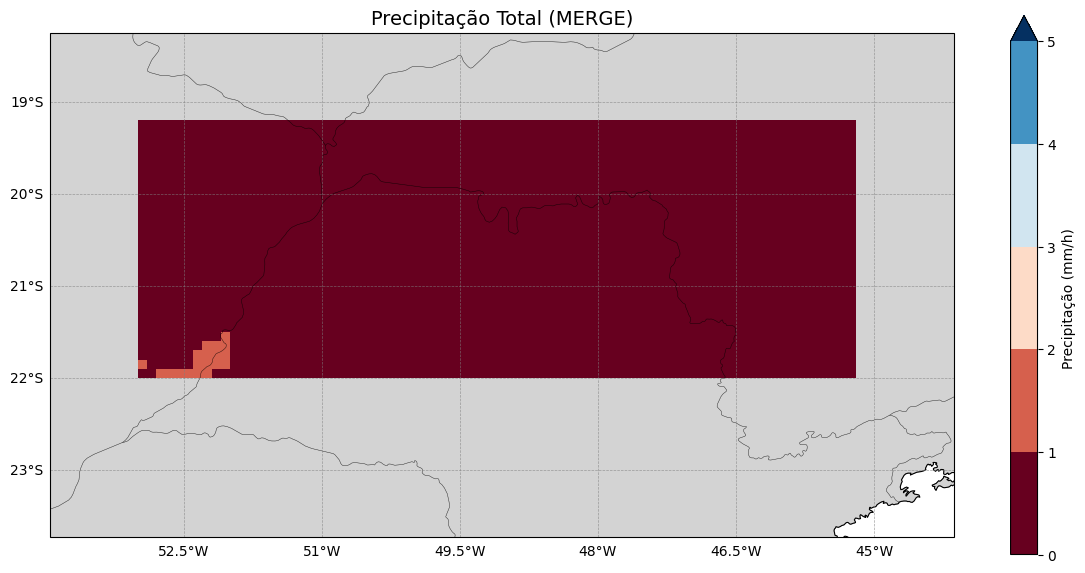

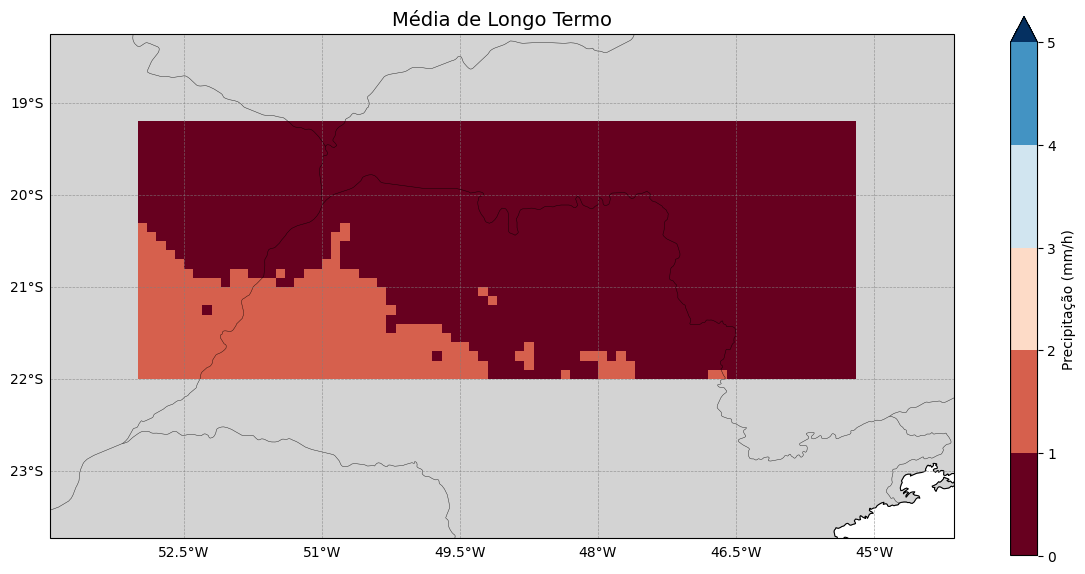

In [79]:
ds_sp_mlt = recortar_dataset_por_regiao(ds_mlt, -52.9518,-45.2291,-22,-19.2479)

plot_precipitacao_merge(ds_sp.mean(dim=['time']), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 5, 6),
                        cmap = 'RdBu')

plot_precipitacao_merge(ds_sp_mlt.mean(dim=['time']), 
                        extent=[-53.9518,-44.1291,-23.7323,-18.2479], 
                        levels=np.linspace(0, 5, 6),
                        var='pmed',
                        cmap = 'RdBu',
                        title='Média de Longo Termo')


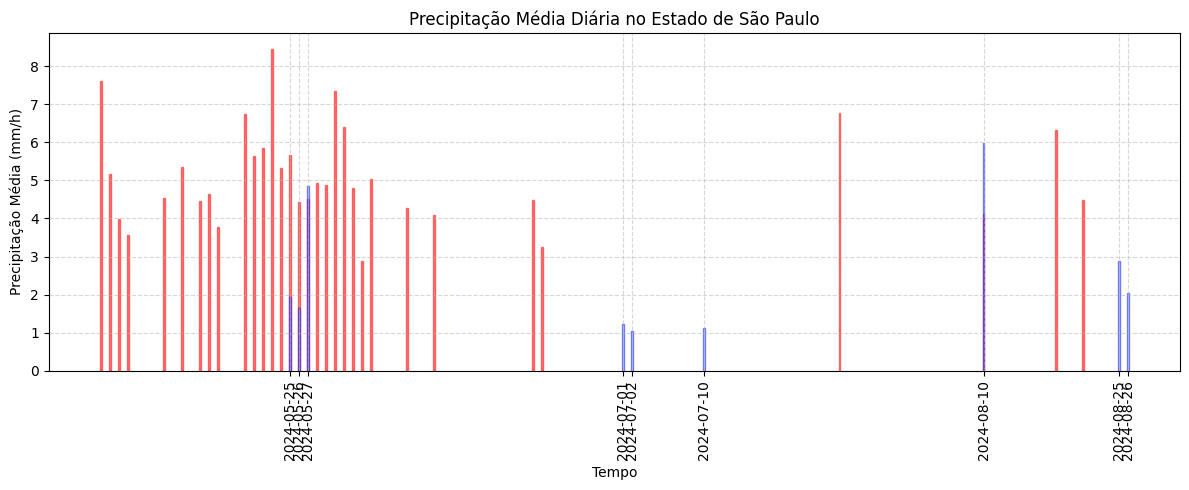

In [83]:
dt = ds_sp['time'][ds_sp['rdp'].mean(axis=[1,2]).values > 1]
tp = ds_sp['rdp'][ds_sp['rdp'].mean(axis=[1,2]).values > 1].mean(axis=[1,2])

dt2 = ds_sp['time'][:123][ds_sp_mlt['pmed'].mean(axis=[1,2]).values > 1]
tp2 = ds_sp_mlt['pmed'][ds_sp_mlt['pmed'].mean(axis=[1,2]).values > 1].max(axis=[1,2])

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(dt2, tp2, width=0.2, color='red', edgecolor='red', alpha=0.5)
ax.bar(dt, tp, width=0.2, color='skyblue', edgecolor='blue', alpha=0.5)

# Mostrar todas as datas
dates = pd.to_datetime(dt.values)
formatted_labels = dates.strftime('%Y-%m-%d')
ax.set_xticks(dt)  # Força todos os ticks
ax.set_xticklabels(formatted_labels, rotation=90)

ax.set_xlabel('Tempo')
ax.set_ylabel('Precipitação Média (mm/h)')
ax.set_title('Precipitação Média Diária no Estado de São Paulo')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
